In [215]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [216]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [217]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [218]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [219]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [220]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [221]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [222]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [223]:
#Look up the first row in measurement table
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2924e30a140>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0}

In [224]:
#Look up the first row in station table
row = session.query(station).first()
row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2924e309690>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [225]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()



('2017-08-23',)

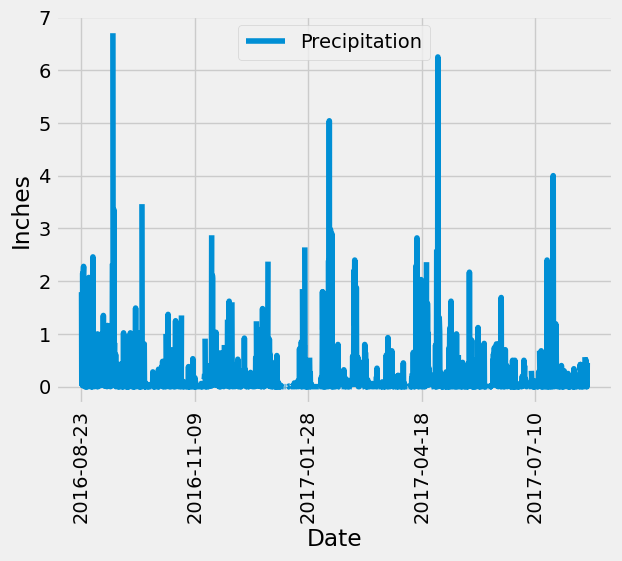

In [226]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

year_ago = session.query(measurement.date, measurement.prcp).\
           filter(measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(year_ago, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace = True)
df.sort_index(inplace=True)


# Sort the dataframe by date
df.sort_values(['Date'], inplace= True)


# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation='vertical')
plt.show()

In [227]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [228]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()


9

In [229]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [231]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)]

results = session.query(*sel).filter(measurement.station == 'USC00519281').all()
results

[(54.0, 85.0, 71.66378066378067)]

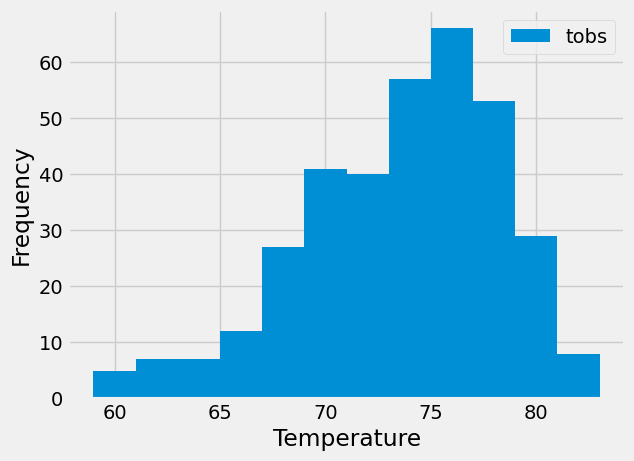

In [232]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

year_ago_temp = session.query(measurement.tobs, measurement.date).\
            filter(measurement.date >= one_year, measurement.station == 'USC00519281')
temp = [{'Temperature': rows[0], "Date": rows[1]} for rows in year_ago_temp ]
temp_df = pd.DataFrame(temp).set_index("Date")

plt.hist(temp_df, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["tobs"],loc='upper right')
plt.show()

# Close Session

In [233]:
# Close Session
session.close()